In [1]:
from flask import Flask
from flask_sqlalchemy import SQLAlchemy
app = Flask(__name__)
app.config['SQLALCHEMY_DATABASE_URI'] = 'postgresql://localhost/racing_data'
db = SQLAlchemy(app)

In [2]:
with app.app_context():
    class TrackDataTable(db.Model):
        __tablename__ = 'nascar_track_data'
        __table_args__ = {'autoload_with': db.engine}
    
    class RaceDataTable(db.Model):
        __tablename__ = 'nascar_race_data'
        __table_args__ = {'autoload_with': db.engine}

    class RaceResultsTable(db.Model):
        __tablename__ = 'nascar_race_results'
        __table_args__ = {'autoload_with': db.engine}  

    class RaceStandingsTable(db.Model):
        __tablename__ = 'nascar_standings'
        __table_args__ = {'autoload_with': db.engine}  

In [3]:
from webpage.utils.tracks_to_types import tracks_to_types, tracks_to_short

with app.app_context():
    class TrackDataTable(db.Model):
        __tablename__ = 'nascar_track_data'
        __table_args__ = {'autoload_with': db.engine}  

    for track_name in tracks_to_types.keys():
        track_type = tracks_to_types[track_name]
        track_short_name = tracks_to_short[track_name]
        track_type_short = ''.join(track_type.split(' '))
        new_row = TrackDataTable(
            track_name=track_name,
            track_short_name=track_short_name,
            track_type=track_type,
            track_type_short=track_type_short,
        )
        db.session.add(new_row)                                      # Add it to the session
        db.session.commit()     

    # all_rows = ExistingTable.query.all()

/Users/demi/miniconda3/envs/raceweb/lib/python3.11/site-packages/flask_sqlalchemy/model.py:144: SAWarning: This declarative base already contains a class with the same class name and module name as __main__.TrackDataTable, and will be replaced in the string-lookup table.
  super().__init__(name, bases, d, **kwargs)


In [3]:
from dataclasses import dataclass
from datetime import date, datetime
import pandas as pd

@dataclass(init=False)
class NascarRaceDataObject:
    season_year: int
    race_name: str
    track_name: str
    race_number: int = 1
    race_date: date
    cautions_number: int
    green_flag_percent: float
    average_green_flag_run_laps: float
    number_of_leaders: int
    average_leading_run_laps: float
    most_laps_led: int
    most_laps_led_driver: str
    most_laps_led_percent: float

season_year = 2024
race_folder = 'Advent Health 400'

def load_track_data(season: int, race_folder: str):
    track_data = pd.read_csv(f'data/{season}/{race_folder}/race_info.csv')
    race_name = track_data['Name of the race'].values[0][5:]
    track_name = track_data['Location'].values[0].split(',')[0]
    raw_race_date = track_data['Date'].values[0]
    race_date = datetime.strptime(raw_race_date, "%A, %B %d, %Y").date()
    return race_name, track_name, race_date

def load_caution_data(season: int, race_folder: str):
    caution_data = pd.read_csv(f'data/{season}/{race_folder}/caution_flags.csv')
    cautions_number = caution_data[caution_data['Condition'] == 'yellow_flag']['# Of Laps'].count()

    n_green_laps = caution_data[caution_data['Condition'] == 'green_flag']['# Of Laps'].sum()
    n_yellow_laps = caution_data[caution_data['Condition'] == 'yellow_flag']['# Of Laps'].sum()
    green_flag_percent = n_green_laps / (n_yellow_laps + n_green_laps)

    average_green_flag_run_laps = caution_data[caution_data['Condition'] == 'green_flag']['# Of Laps'].mean()
    return cautions_number, green_flag_percent, average_green_flag_run_laps

def load_leaders_data(season: int, race_folder: str):
    leaders_data = pd.read_csv(f'data/{season}/{race_folder}/lap_leaders.csv')
    number_of_leaders = leaders_data['Leader'].nunique()
    average_leading_run_laps = leaders_data['# Of Laps'].mean()
    leaders = leaders_data[['Leader', '# Of Laps']].groupby(
        'Leader', as_index=False
        ).sum().sort_values('# Of Laps', ascending=False)
    most_laps_led = leaders['# Of Laps'].values[0]
    most_laps_led_driver = leaders['Leader'].values[0]
    most_laps_led_percent = most_laps_led / leaders['# Of Laps'].sum()
    return number_of_leaders, average_leading_run_laps, most_laps_led, most_laps_led_driver, most_laps_led_percent

def fill_race_data() -> NascarRaceDataObject:
    race_data_row = NascarRaceDataObject()
    race_data_row.season_year = season_year

    race_name, track_name, race_date = load_track_data(season_year, race_folder)
    race_data_row.race_name = race_name
    race_data_row.track_name = track_name
    race_data_row.race_date = race_date

    cautions_number, green_flag_percent, average_green_flag_run_laps = load_caution_data(season_year, race_folder)
    race_data_row.cautions_number = int(cautions_number)
    race_data_row.green_flag_percent = float(green_flag_percent)
    race_data_row.average_green_flag_run_laps = float(average_green_flag_run_laps)

    (number_of_leaders,
     average_leading_run_laps,
     most_laps_led,
     most_laps_led_driver,
     most_laps_led_percent) = load_leaders_data(season_year, race_folder)
    race_data_row.number_of_leaders = int(number_of_leaders)
    race_data_row.average_leading_run_laps = float(average_leading_run_laps)
    race_data_row.most_laps_led = int(most_laps_led)
    race_data_row.most_laps_led_driver = most_laps_led_driver
    race_data_row.most_laps_led_percent = float(most_laps_led_percent)

    return race_data_row

In [6]:
from webpage.utils.owners_to_teams import owners_to_teams

@dataclass(init=False)
class NascarRaceResultsObject:
    season_year: int
    race_number: int
    driver_name: str
    car_number: int
    team_name: str
    manufacturer: str
    race_pos: int
    quali_pos: int
    stage_1_pos: int
    stage_2_pos: int
    laps_led: int
    status: str
    season_points: int
    finish_position_points: int
    stage_points: int
    playoff_points: int

@dataclass(init=False)
class NascarStandingsObject:
    season_year: int
    race_number: int
    driver_name: str
    race_season_points: int
    wins: int
    stage_wins: int
    race_playoff_points: int

season_year = 2024
race_folder = 'Advent Health 400'

def fix_team_names(team_names: str) -> str:
    return owners_to_teams[team_names.split('(')[-1].strip(')')]

def load_stage_data(season: int, race_folder: str):
    stage_data = pd.read_csv(f'data/{season}/{race_folder}/top_10s.csv')
    stage_1 = [int(number.strip('#')) for number in stage_data["Top 10 in Stage 1:"].values]
    stage_2 = [int(number.strip('#')) for number in stage_data["Top 10 in Stage 2:"].values]
    stage_1_df = pd.DataFrame({'#': stage_1, 'stage_1_pos': list(range(1, 11))})
    stage_2_df = pd.DataFrame({'#': stage_2, 'stage_2_pos': list(range(1, 11))})
    stages_results = stage_1_df.merge(stage_2_df, on='#', how='outer')
    return stages_results


def fill_results_data(season: int, race_folder: str):
    results_data = pd.read_csv(f'data/{season}/{race_folder}/race_results.csv')
    stages_results = load_stage_data(season, race_folder)
    results_data = results_data.merge(stages_results, on='#').fillna(0)
    
    driver_names = results_data['Driver'].values
    car_numbers = [int(number) for number in results_data['#'].values]
    team_names = [fix_team_names(team_name) for team_name in results_data['Sponsor / Owner'].values]
    manufacturers = results_data['Car'].values
    race_pos = [int(pos) for pos in results_data['Pos'].values]
    quali_pos = [int(pos) for pos in results_data['St'].values]
    stage_1_pos = [int(pos) for pos in results_data['stage_1_pos'].values]
    stage_2_pos = [int(pos) for pos in results_data['stage_2_pos'].values]
    laps_leds = [int(laps) for laps in results_data['Led'].values]
    statuses = results_data['Status'].values
    season_points = [int(pts) for pts in results_data['Pts'].values]
    playoff_points = [int(pts) for pts in results_data['PPts'].values]
    finish_position_points = [40] + list(range(35, 0, -1)) + [1] * (results_data.shape[0] - 36)
    results_data['stage_1_points'] = [11 - stage_pos if stage_pos <= 10 else 0 for stage_pos in results_data['stage_1_pos']]
    results_data['stage_2_points'] = [11 - stage_pos if stage_pos <= 10 else 0 for stage_pos in results_data['stage_2_pos']]
    stage_points = [int(pts) for pts in (results_data['stage_1_points'] + results_data['stage_2_points']).values]
    wins = [1 if pos == 1 else 0 for pos in race_pos]
    stage_wins = [2 if (pos_stage_1 == 1) and (pos_stage_2 == 1) \
                  else 1 if (pos_stage_1 == 1) or (pos_stage_2 == 1) \
                    else 0 for pos_stage_1, pos_stage_2 in zip(stage_1_pos, stage_2_pos)]
    race_results = []
    for i in range(results_data.shape[0]):
        race_results_row = NascarRaceResultsObject()
        race_results_row.season_year = season_year
        race_results_row.race_number = 1
        race_results_row.driver_name = driver_names[i]
        race_results_row.car_number = car_numbers[i]
        race_results_row.team_name = team_names[i]
        race_results_row.manufacturer = manufacturers[i]
        race_results_row.race_pos = race_pos[i]
        race_results_row.quali_pos = quali_pos[i]
        race_results_row.stage_1_pos = stage_1_pos[i]
        race_results_row.stage_2_pos = stage_2_pos[i]
        race_results_row.laps_led = laps_leds[i]
        race_results_row.status = statuses[i]
        race_results_row.season_points = season_points[i]
        race_results_row.finish_position_points = finish_position_points[i]
        race_results_row.stage_points = stage_points[i]
        race_results_row.playoff_points = playoff_points[i]
        race_results.append(race_results_row)
        
    standings = []
    for i in range(results_data.shape[0]):
        race_standings_row = NascarStandingsObject()
        race_standings_row.season_year = season_year
        race_standings_row.race_number = 1
        race_standings_row.driver_name = driver_names[i]
        race_standings_row.race_season_points = season_points[i]
        race_standings_row.wins = wins[i]
        race_standings_row.stage_wins = stage_wins[i]
        race_standings_row.race_playoff_points = playoff_points[i]
        standings.append(race_standings_row)
    return race_results, standings

In [7]:
race_results, standings = fill_results_data(season_year, race_folder)

from sqlalchemy.exc import IntegrityError

with app.app_context():
    for data in race_results:
        new_data = RaceResultsTable(
            season_year=data.season_year,
            race_number=data.race_number,
            driver_name=data.driver_name,
            car_number=data.car_number,
            team_name=data.team_name,
            manufacturer=data.manufacturer,
            race_pos=data.race_pos,
            quali_pos=data.quali_pos,
            stage_1_pos=data.stage_1_pos,
            stage_2_pos=data.stage_2_pos,
            laps_led=data.laps_led,
            status=data.status,
            season_points=data.season_points,
            finish_position_points=data.finish_position_points,
            stage_points=data.stage_points,
            playoff_points=data.playoff_points,
        )
        try:
            db.session.add(new_data)
            db.session.commit()
        except IntegrityError as e:
            db.session.rollback()

    for data in standings:
        new_data = RaceStandingsTable(
            season_year=data.season_year,
            race_number=data.race_number,
            driver_name=data.driver_name,
            race_season_points=data.race_season_points,
            wins=data.wins,
            stage_wins=data.stage_wins,
            race_playoff_points=data.race_playoff_points,
        )
        try:
            db.session.add(new_data)
            db.session.commit()
        except IntegrityError as e:
            db.session.rollback()

In [ ]:


season_year = 2024
race_folder = 'Advent Health 400'


def load_stage_data(season: int, race_folder: str):
    stage_data = pd.read_csv(f'data/{season}/{race_folder}/top_10s.csv')
    stage_1 = [int(number.strip('#')) for number in stage_data["Top 10 in Stage 1:"].values]
    stage_2 = [int(number.strip('#')) for number in stage_data["Top 10 in Stage 2:"].values]
    stage_1_df = pd.DataFrame({'#': stage_1, 'stage_1_pos': list(range(1, 11))})
    stage_2_df = pd.DataFrame({'#': stage_2, 'stage_2_pos': list(range(1, 11))})
    stages_results = stage_1_df.merge(stage_2_df, on='#', how='outer')
    return stages_results

def fill_results_data(season: int, race_folder: str):
    results_data = pd.read_csv(f'data/{season}/{race_folder}/race_results.csv')
    stages_results = load_stage_data(season, race_folder)
    results_data = results_data.merge(stages_results, on='#').fillna(0)

In [21]:
data = fill_race_data()
data

NascarRaceDataObject(season_year=2024, race_name='Advent Health 400', track_name='Kansas Speedway', race_number=1, race_date=datetime.date(2024, 5, 5), cautions_number=7, green_flag_percent=0.8395522388059702, average_green_flag_run_laps=28.125, number_of_leaders=10, average_leading_run_laps=9.241379310344827, most_laps_led=71, most_laps_led_driver='Denny Hamlin', most_laps_led_percent=0.26492537313432835)

In [22]:
data = fill_race_data()

with app.app_context():
    new_data = RaceDataTable(
        season_year=data.season_year,
        race_name=data.race_name,
        track_name=data.track_name,
        race_number=data.race_number,
        race_date=data.race_date,
        cautions_number=data.cautions_number,
        green_flag_percent=data.green_flag_percent,
        average_green_flag_run_laps=data.average_green_flag_run_laps,
        number_of_leaders=data.number_of_leaders,
        average_leading_run_laps=data.average_leading_run_laps,
        most_laps_led=data.most_laps_led,
        most_laps_led_driver=data.most_laps_led_driver,
        most_laps_led_percent=data.most_laps_led_percent,
    )
    db.session.add(new_data)                                      # Add it to the session
    db.session.commit()     

In [5]:
from webpage.utils.tracks_to_types import tracks_to_types, tracks_to_short

for track_name in tracks_to_types.keys():
    track_type = tracks_to_types[track_name]
    track_short_name = tracks_to_short[track_name]
    track_type_short = "".join([word[0] for word in track_type.split(' ')])
    print(track_type_short)

I
I
ST
RC
I
RC
RC
I
RC
RC
I
S
I
ST
I
I
RC
ST
I
I
ST
I
ST
ST
ST
I
RC
ST
I
I
ST
I
I
RC
ST
RC
RC
RC
S
I
RC
I


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def fu(x):
    sig = 1 / (1 + np.exp(-x))
    return x * sig

xs = [x / 1000 for x in range(-10000, 2000)]
ys = [fu(x) for x in xs]

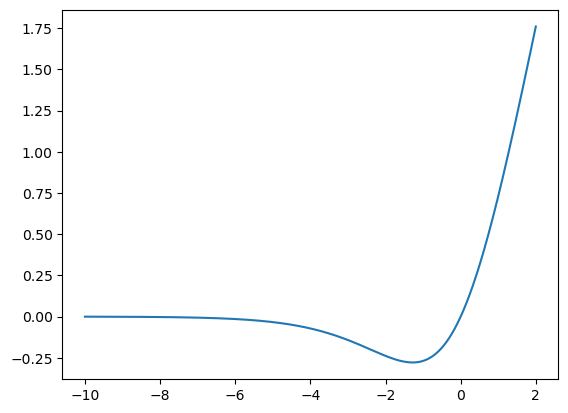

In [4]:
plt.plot(xs, ys)

In [7]:
np.log(0.1)

-2.3025850929940455